In [9]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset, singleCET_ProjectedDataset
from cryoS2Sdrop.model import Denoising_3DUNet, Denoising_3DUNet_v2
from cryoS2Sdrop.losses import self2self_L2Loss
from cryoS2Sdrop.trainer import denoisingTrainer
from cryoS2Sdrop.predict import load_model, predict_full_tomogram

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
import pathlib
import json

from torchsummary import summary
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

PARENT_PATH = setup.PARENT_PATH

def parse_null_arg(arg, dtype):
    try:
        return dtype(arg)
    except ValueError:
        return None

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
###################### Parse arguments ###################

exp_name = "realBernoulli_dropoutLevel_comparison"

n_bernoulli_samples = 12

tomo_name = "tomoPhantom_model8_noisyGaussPoissL"

version = "version_3"

##################################### Model and dataloader ####################################################

tensorboard_logdir = os.path.join(
    PARENT_PATH, "data/S2SDenoising/model_logs/%s/%s/" % (tomo_name, exp_name)
)
pathlib.Path(tensorboard_logdir).mkdir(parents=True, exist_ok=True)

# use the last version for the predictions
if version is None:
    version = len(glob(tensorboard_logdir + "/version*")) - 1
    version = "version_%i" % version

logdir = os.path.join(tensorboard_logdir, version)

with open(os.path.join(logdir, "experiment_args.json"), "r") as f:
    exp_args = json.load(f)

deconv_kwargs = exp_args["deconv_kwargs"]
predict_simRecon = exp_args["predict_simRecon"]
use_deconv_as_target = exp_args["use_deconv_as_target"]
weightedBernoulliMask_prob = parse_null_arg(
    exp_args["weightedBernoulliMask_prob"], float
)

print("Loading model from: %s" % logdir)

model, hparams = load_model(logdir, DataParallel=True)

dataset = hparams["dataset"]

cet_path = hparams["tomo_path"]
gt_cet_path = hparams["gt_tomo_path"]
p = float(hparams["p"])  # dropout (zeroing) probability
subtomo_length = int(hparams["subtomo_length"])
n_features = int(hparams["n_features"])
volumetric_scale_factor = parse_null_arg(hparams["vol_scale_factor"], float)
Vmask_probability = parse_null_arg(hparams["Vmask_probability"], float)
Vmask_pct = parse_null_arg(hparams["Vmask_pct"], float)
alpha = hparams["loss_fn"]["alpha"]

if dataset == "singleCET_dataset":
    my_dataset = singleCET_dataset(
        cet_path,
        subtomo_length=subtomo_length,
        p=p,
        n_bernoulli_samples=n_bernoulli_samples,
        volumetric_scale_factor=volumetric_scale_factor,
        Vmask_probability=Vmask_probability,
        Vmask_pct=Vmask_pct,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        **deconv_kwargs
    )

elif dataset == "singleCET_FourierDataset":
    my_dataset = singleCET_FourierDataset(
        cet_path,
        subtomo_length=subtomo_length,
        p=p,
        n_bernoulli_samples=n_bernoulli_samples,
        volumetric_scale_factor=volumetric_scale_factor,
        Vmask_probability=Vmask_probability,
        Vmask_pct=Vmask_pct,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        weightedBernoulliMask_prob=weightedBernoulliMask_prob,
        **deconv_kwargs
    )

elif dataset == "singleCET_ProjectedDataset":
    my_dataset = singleCET_ProjectedDataset(
        cet_path,
        subtomo_length=subtomo_length,
        transform=None,
        n_shift=0,
        gt_tomo_path=gt_cet_path,
        predict_simRecon=predict_simRecon,
        use_deconv_as_target=use_deconv_as_target,
        **deconv_kwargs
    )

Loading model from: /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissL/realBernoulli_dropoutLevel_comparison/version_3


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [7]:
def aux_forward(model, dataset, idx, masked_only):
    with torch.no_grad():
        subtomo, target, mask = dataset[idx]
        if masked_only:
            return (1-mask).cuda()*model(subtomo)
        else:
            return model(subtomo)
    
def aux_unpack_stuff(logdir, version):
    logdir = os.path.join(PARENT_PATH, 'data/S2SDenoising/%s/%s/' %(logdir, version))
    model, hparams = load_model(logdir, DataParallel=True)

    cet_path = hparams['cet_path']
    p = float(hparams['p']) # dropout (zeroing) probability
    subtomo_length = int(hparams['subtomo_length'])
    n_features = int(hparams['n_features'])
    vol_scale_factor = int(hparams['singleCET_dataset.vol_scale_factor'])
    n_bernoulli_samples = int(hparams['singleCET_dataset.n_bernoulli_samples'])
    Vmask_probability = float(hparams['singleCET_dataset.Vmask_probability'])

    print('- %s: %s' %(version, hparams['Version_comment']))

    my_dataset = singleCET_dataset(cet_path, subtomo_length, p=p, volumetric_scale_factor=vol_scale_factor, n_bernoulli_samples=n_bernoulli_samples)
    my_dataset.Vmask_probability = Vmask_probability
    
    return model, my_dataset

def compare_one_subtomo_model_versions(version_list, logdir, masked_only):
    denoised_dict = {}
    
    for version in version_list:
        
        model, my_dataset = aux_unpack_stuff(logdir, version)
        zidx = my_dataset.subtomo_length//2
        
        idx = 30
        subtomo, target, mask = my_dataset[idx]
        aux_subtomo = (target + subtomo)
        print(aux_subtomo.shape)
        original_subtomo = aux_subtomo.squeeze(1).detach().numpy()[0]
        n0 = 12//len(aux_subtomo)
        n1 = 300//len(aux_subtomo)

        denoised_subtomo0 = torch.stack([aux_forward(model, my_dataset, idx=idx, masked_only=masked_only) for i in range(n0)]).flatten(0, 2).cpu().detach().numpy()#.mean(0)
        denoised_subtomo1 = torch.stack([aux_forward(model, my_dataset, idx=idx, masked_only=masked_only) for i in range(n1)]).flatten(0, 2).cpu().detach().numpy()#.mean(0)
        
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(22, 10))
        ax0.imshow(denoised_subtomo0.mean(0)[zidx])
        ax0.set_title('Prediction with shape %s' %str(denoised_subtomo0.shape))
        ax1.imshow(denoised_subtomo1.mean(0)[zidx])
        ax1.set_title('Prediction with shape %s' %str(denoised_subtomo1.shape))
        ax2.imshow(original_subtomo[zidx])
        ax2.set_title('Original')
        plt.show()
        denoised_dict[version] = [denoised_subtomo0, denoised_subtomo1]
    
    return denoised_dict
        

# Predict one subtomo

In [8]:
max_version = 7
version_list = ['version_%i'%i for i in range(max_version+1)]
# version_list = ['version_6']
logdir = 'tryout_model_logs'

- version_0: Model to check individual behavior of predictions. Masks are deterministic and only one mask is used.
torch.Size([6, 1, 96, 96, 96])


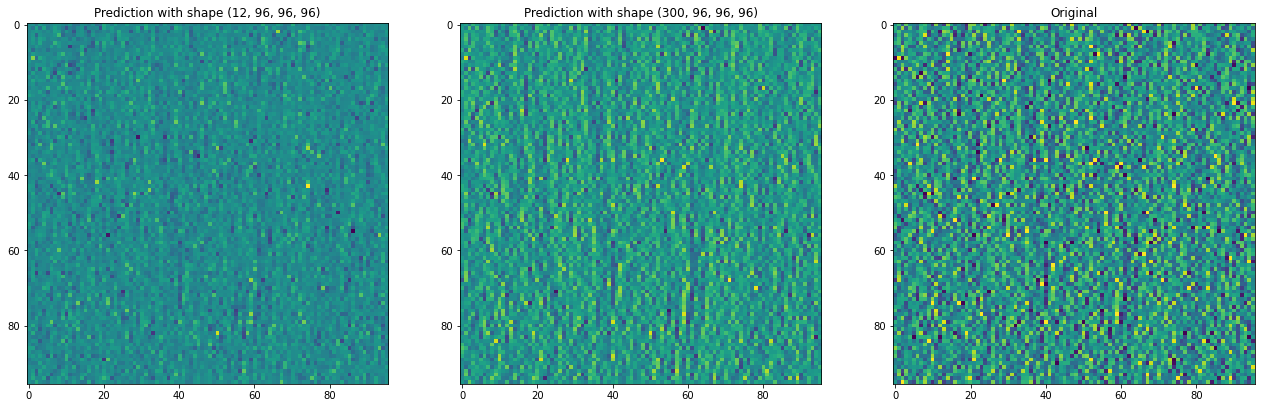

- version_1: Check model behavior with random pointed mask taken from a predefined set of mask samples
torch.Size([6, 1, 96, 96, 96])


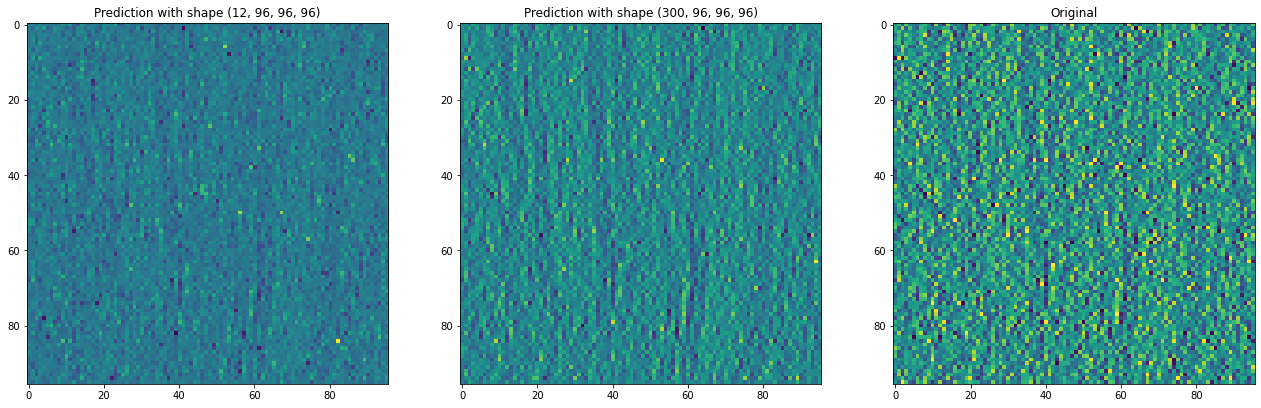

- version_2: One different pointed mask batch for each __getitem__ call
torch.Size([6, 1, 96, 96, 96])


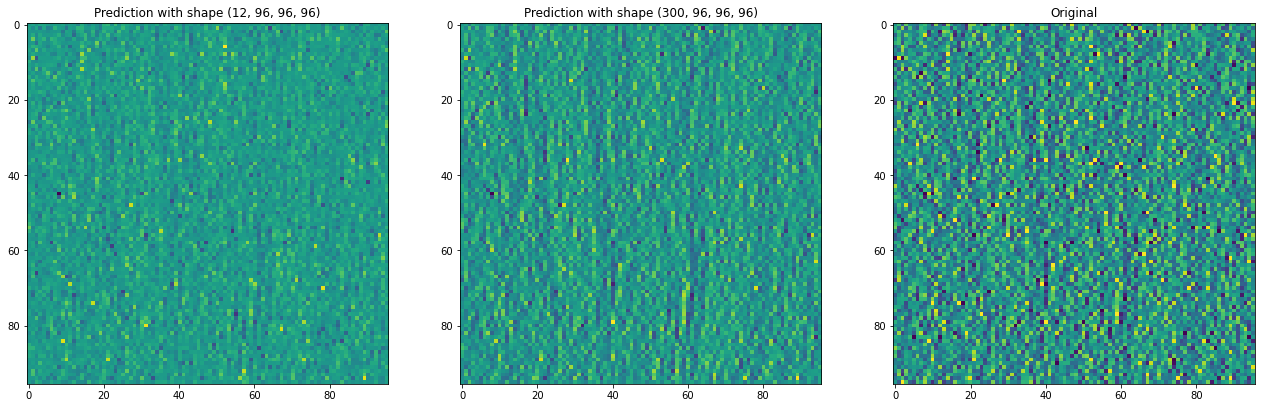

- version_3: One different mask batch for each __getitem__ call. Use Vmask at p0=0.1 with probability 0.5.
torch.Size([6, 1, 96, 96, 96])


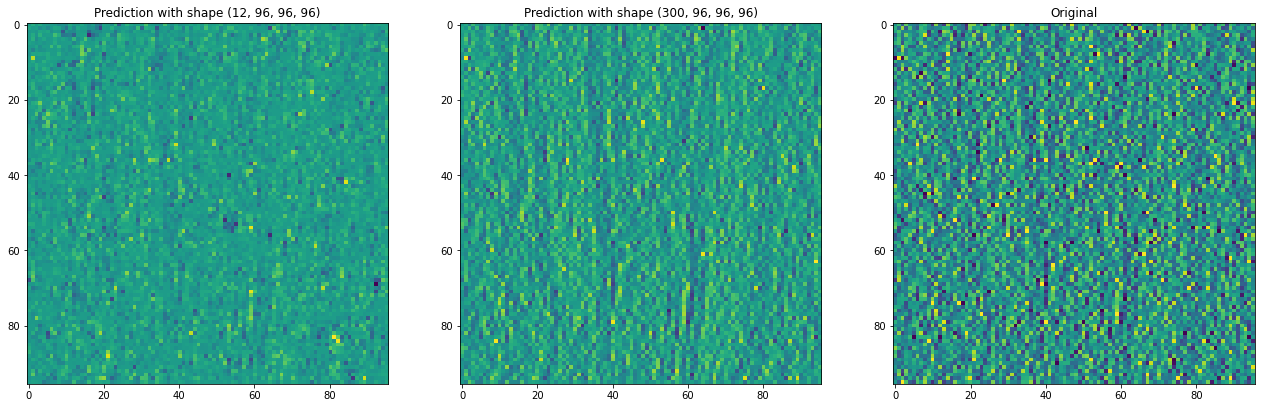

- version_4: One different Volumetric mask batch for each __getitem__ call. Use Vmask at p0=0.1.
torch.Size([6, 1, 96, 96, 96])


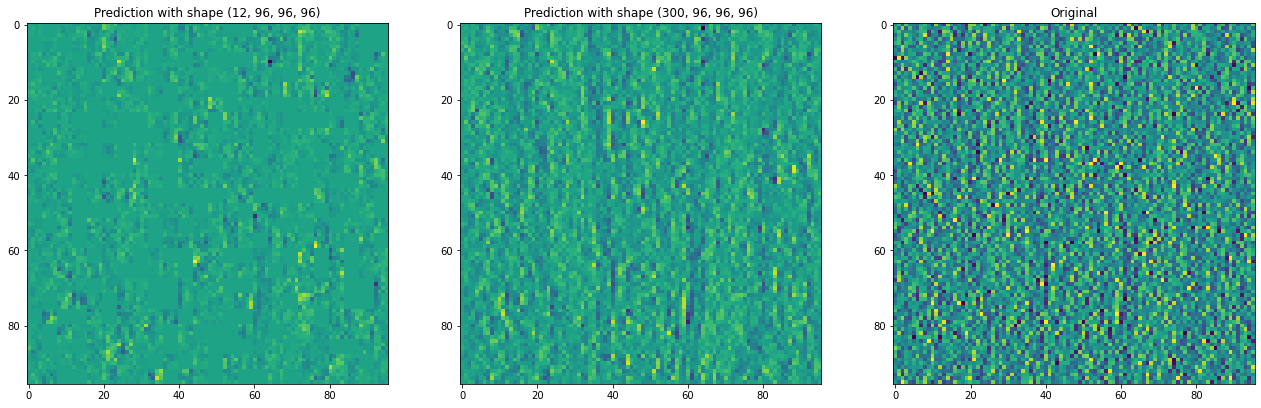

- version_5: Set bernoulli samples to 1 and pointed mask.
torch.Size([1, 1, 96, 96, 96])


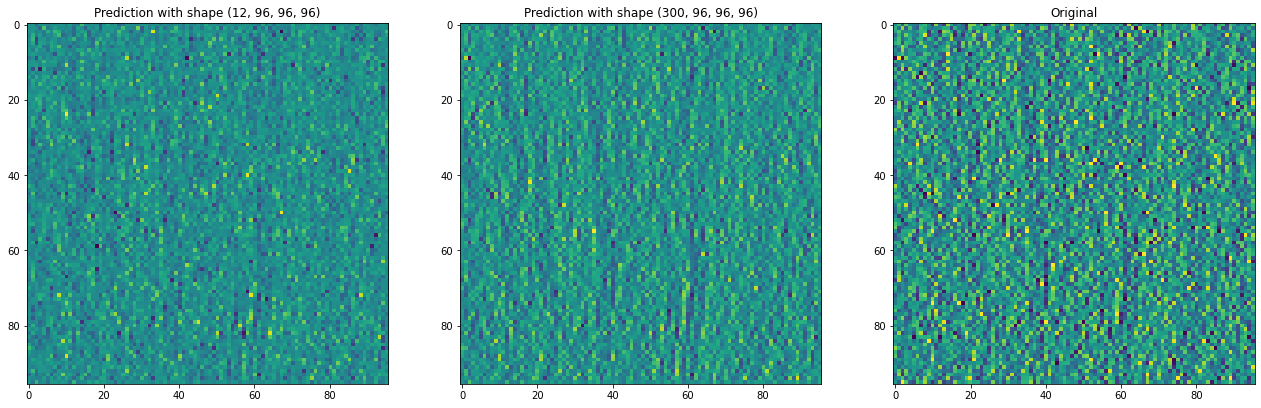

- version_6: Set bernoulli samples to 1 and pointed mask. 100 epochs
torch.Size([1, 1, 96, 96, 96])


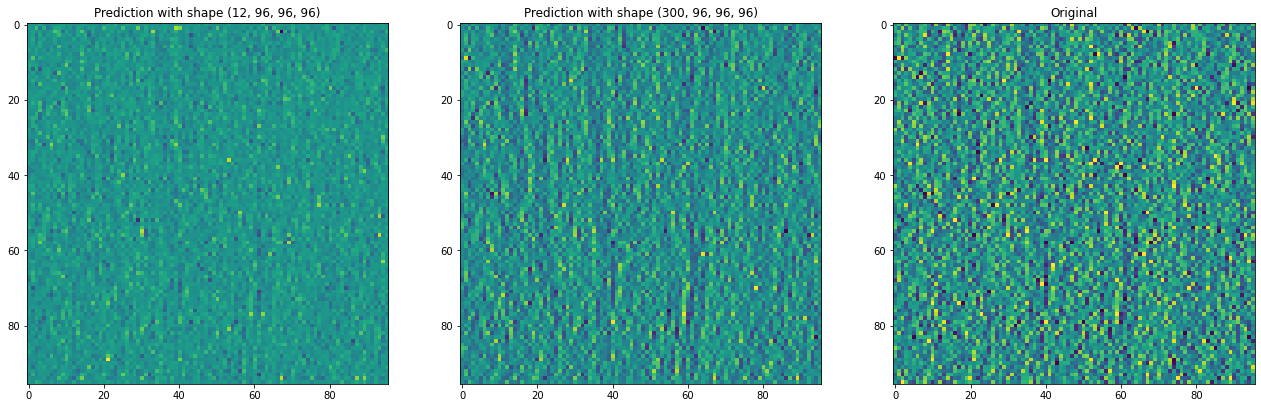

- version_7: 12 Bernoulli samples. Different pointed mask per iteration
torch.Size([12, 1, 96, 96, 96])


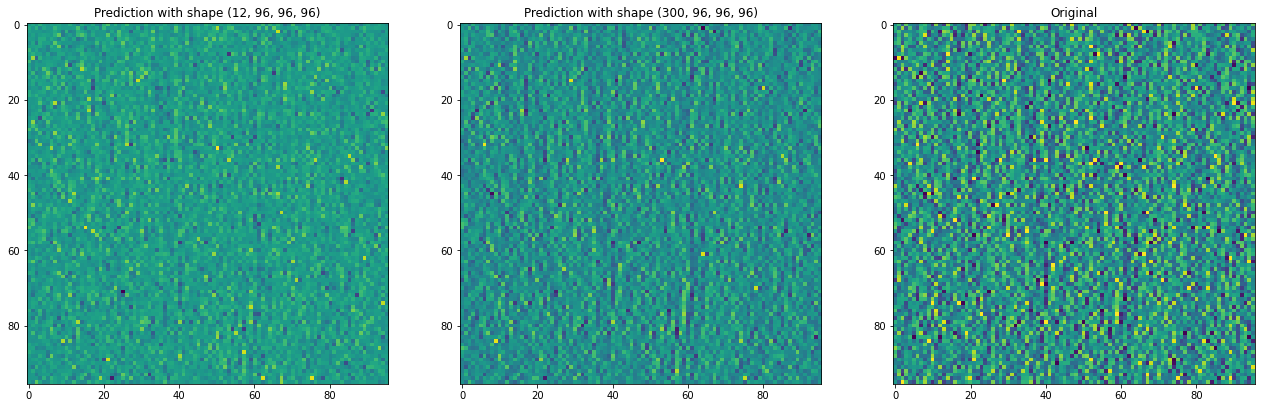

In [9]:
denoised_dict = compare_one_subtomo_model_versions(version_list, logdir, masked_only=True)

- version_0: Model to check individual behavior of predictions. Masks are deterministic and only one mask is used.
torch.Size([6, 1, 96, 96, 96])


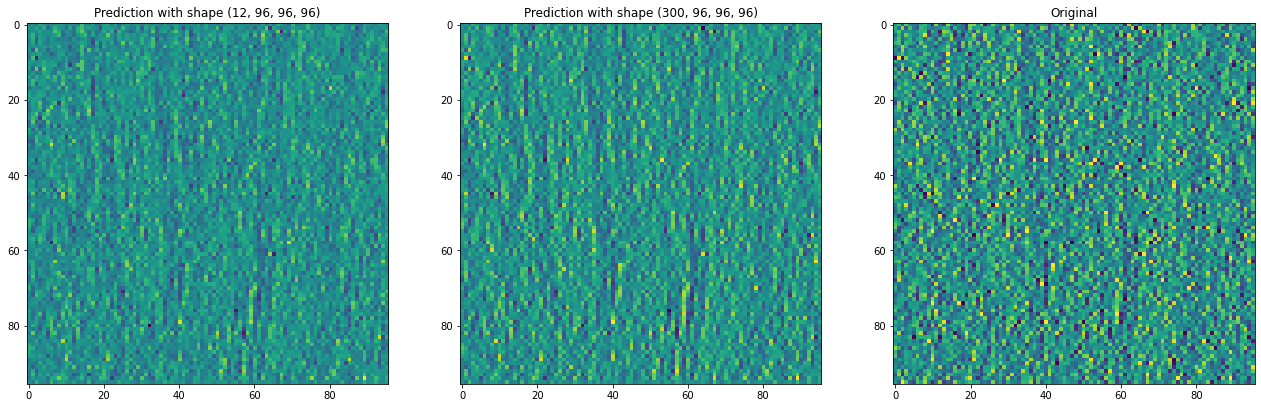

- version_1: Check model behavior with random pointed mask taken from a predefined set of mask samples
torch.Size([6, 1, 96, 96, 96])


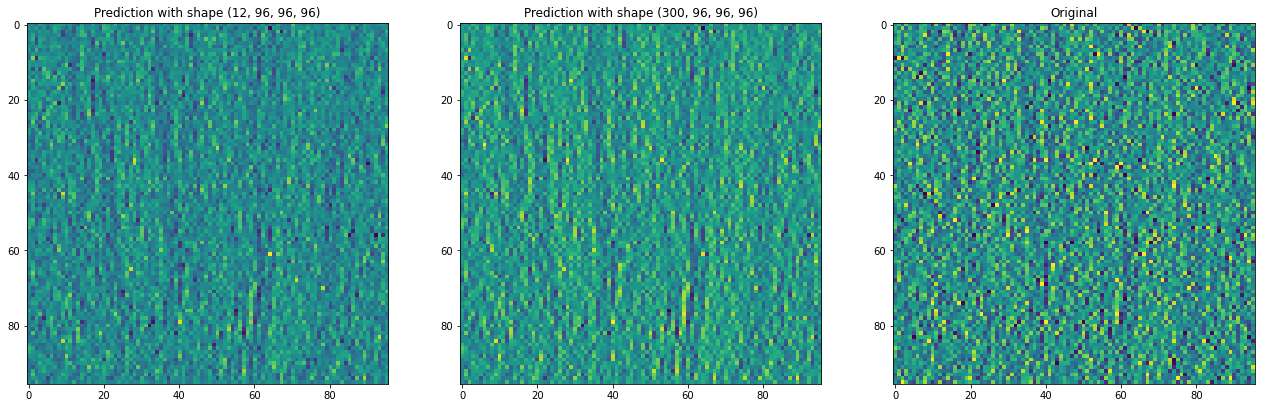

- version_2: One different pointed mask batch for each __getitem__ call
torch.Size([6, 1, 96, 96, 96])


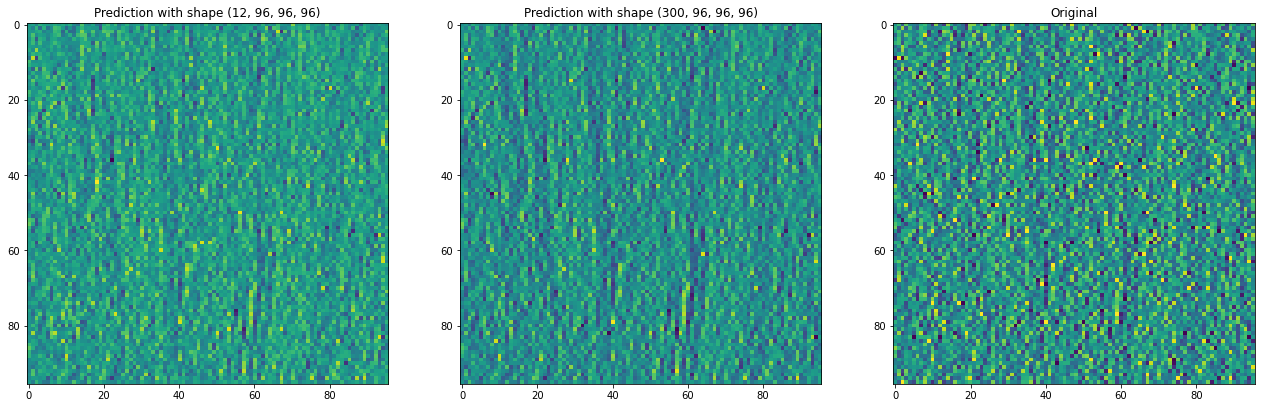

- version_3: One different mask batch for each __getitem__ call. Use Vmask at p0=0.1 with probability 0.5.
torch.Size([6, 1, 96, 96, 96])


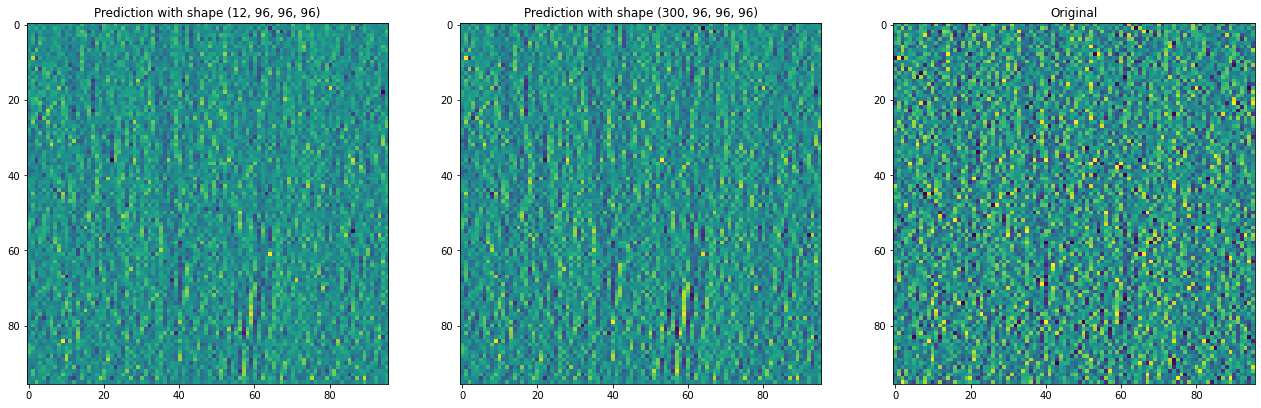

- version_4: One different Volumetric mask batch for each __getitem__ call. Use Vmask at p0=0.1.
torch.Size([6, 1, 96, 96, 96])


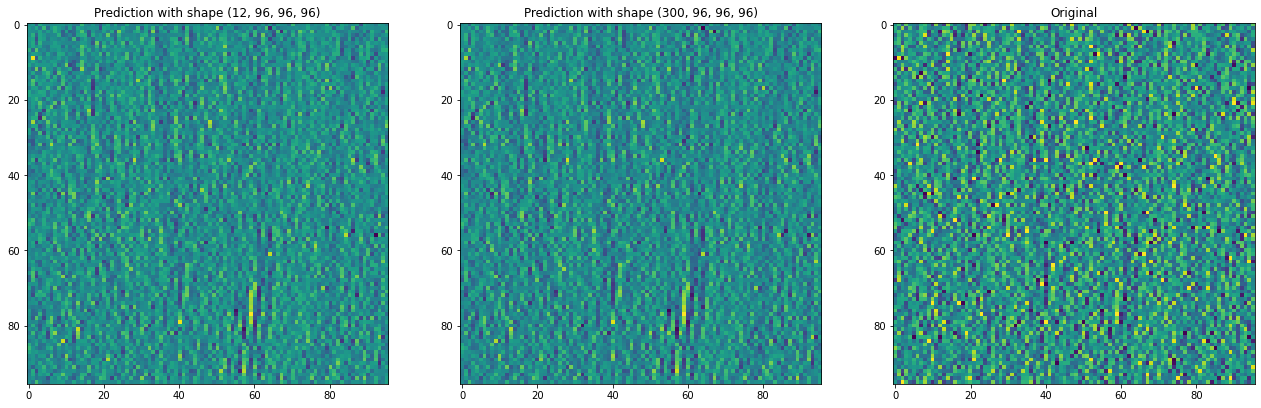

- version_5: Set bernoulli samples to 1 and pointed mask.
torch.Size([1, 1, 96, 96, 96])


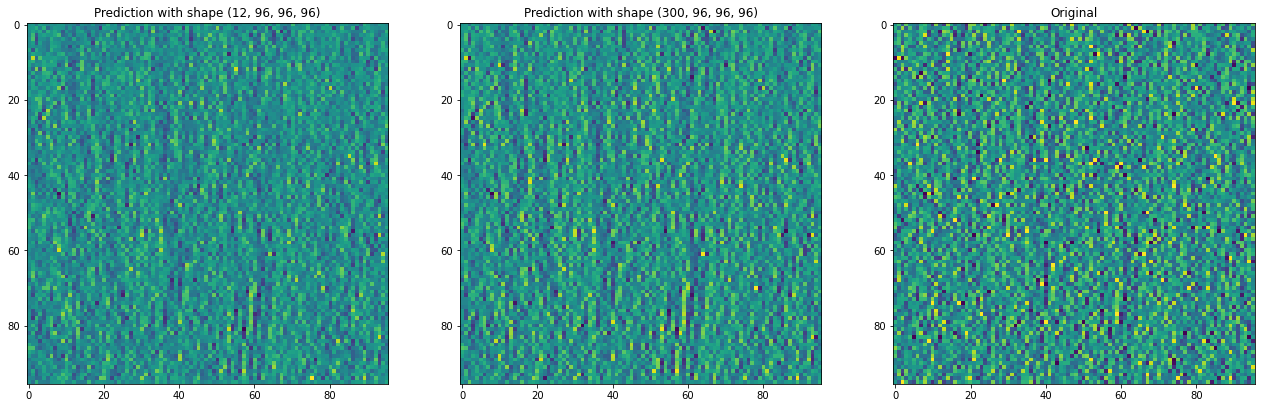

- version_6: Set bernoulli samples to 1 and pointed mask. 100 epochs
torch.Size([1, 1, 96, 96, 96])


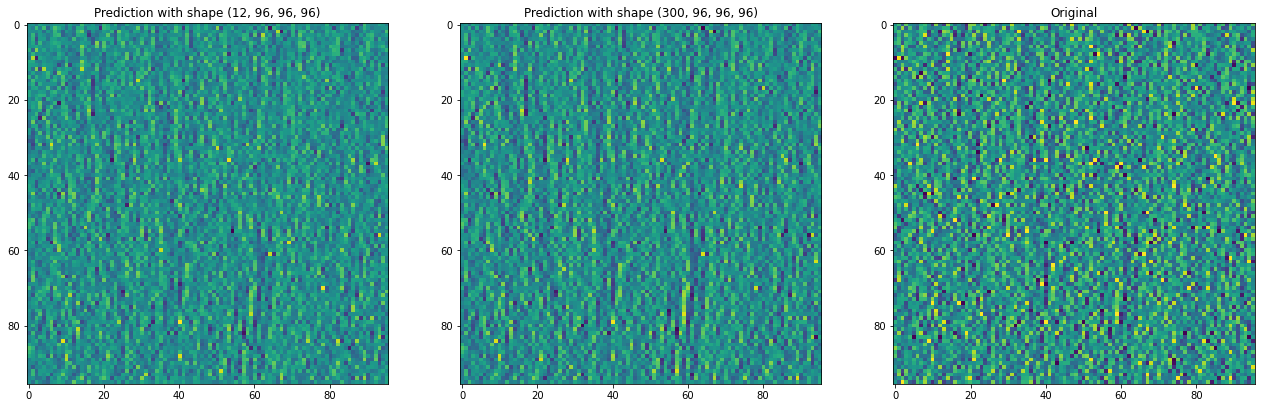

- version_7: 12 Bernoulli samples. Different pointed mask per iteration
torch.Size([12, 1, 96, 96, 96])


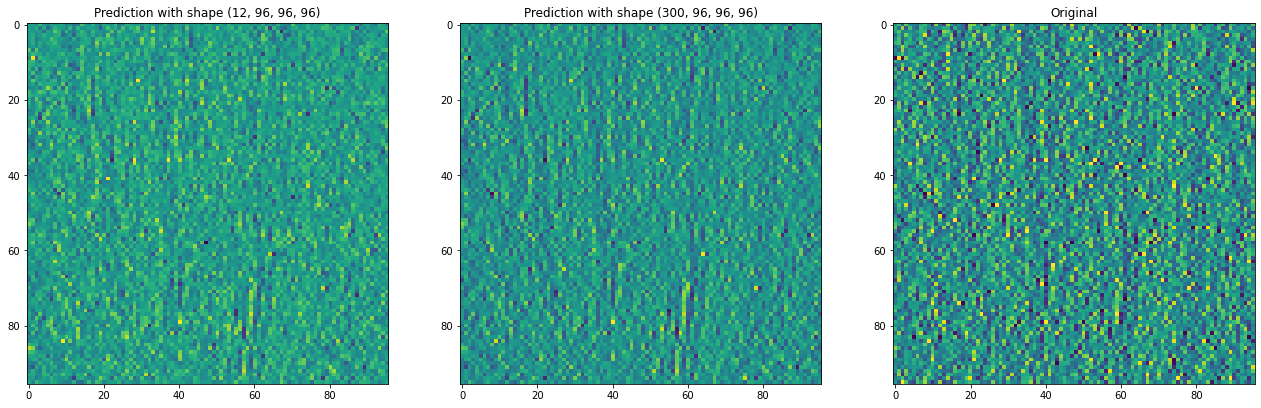

In [10]:
denoised_dict = compare_one_subtomo_model_versions(version_list, logdir, masked_only=False)